In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
last_skywalker = np.array([0.98,0.9,-0.9])
user1 = np.array([0.9,0.8,-0.6])
casablanca = np.array([-0.99,-0.3,0.8])

In [5]:
(last_skywalker*user1).sum(axis=0)

2.1420000000000003

In [6]:
(user1*casablanca).sum()

-1.611

In [7]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### DataLoaders

In [9]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [10]:
n_user = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_user,n_factors)
movie_factors = torch.randn(n_movies,n_factors)


In [11]:
one_hot_3 = one_hot(3,n_user).float()

In [12]:
user_factors.shape,one_hot_3.shape, n_user

(torch.Size([944, 5]), torch.Size([944]), 944)

In [13]:
user_factors.t()@ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [14]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Creating our CF from scratch


In [15]:
class DotProduct(Module):
  def __init__(self,n_user,n_movies,n_factors):
    self.user_factors = Embedding(n_user, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users*movies).sum(dim=1)

In [16]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [17]:
model = DotProduct(n_user,n_movies,50)
Learn = Learner(dls,model,loss_func=MSELossFlat() )

In [18]:
Learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:22
1,1.093332,1.109981,00:12
2,0.958258,0.990199,00:12
3,0.814234,0.894916,00:12
4,0.780714,0.882022,00:12


In [19]:
class DotProduct(Module):
  def __init__(self,n_user,n_movies,n_factors,y_range=(0,5.5)):
    self.user_factors = Embedding(n_user, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users*movies).sum(dim=1),*self.y_range)

In [20]:
# this is run after sigmoid_range is added to the DotProduct classs
model = DotProduct(n_user,n_movies,50)
Learn = Learner(dls,model,loss_func=MSELossFlat())
Learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:12
1,0.878134,0.918898,00:12
2,0.675850,0.875467,00:14
3,0.483372,0.877939,00:13
4,0.378927,0.881887,00:12


In [21]:
class DotProduct(Module):
  def __init__(self,n_user,n_movies,n_factors,y_range=(0,5.5)):
    self.user_factors = Embedding(n_user, n_factors)
    self.user_bias = Embedding(n_user,1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies,1)
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users*movies).sum(dim=1, keepdim=True)
    res += (self.user_bias(x[:,0])) + self.movie_bias(x[:,1])
    return sigmoid_range(res,*self.y_range)

In [22]:
# this is run after bias is added to the DotProduct classs
model = DotProduct(n_user,n_movies,50)
Learn = Learner(dls,model,loss_func=MSELossFlat())
Learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:13
1,0.846664,0.865633,00:13
2,0.608090,0.865127,00:13
3,0.413482,0.887318,00:12
4,0.286971,0.894876,00:13


### Weight Decay 0r L2 Regularization

* loss_with_wd = loss + wd *(parameters**2).sum()
* parameters.grad + = wd * 2 * parameters

In [23]:
# this is run after wd (weight decay) is added to the DotProduct classs
model = DotProduct(n_user,n_movies,50)
Learn = Learner(dls,model,loss_func=MSELossFlat())
Learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:13
1,0.888625,0.882614,00:13
2,0.771066,0.832743,00:13
3,0.599807,0.822374,00:13
4,0.504981,0.822528,00:14


## Creating our own Module

In [24]:
class T(Module):
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [25]:
x= torch.ones(3);x

tensor([1., 1., 1.])

In [26]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

t=T()
L(t.parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [27]:
class T(Module):
  def __init__(self): self.a = nn.Linear(1,3,bias=False)

t=T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [28]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [29]:
def creat_param(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [30]:
class DotProduct(Module):
  def __init__(self,n_user,n_movies,n_factors,y_range=(0,5.5)):
    self.user_factors = creat_param([n_user, n_factors])
    self.user_bias = creat_param([n_user])
    self.movie_factors = creat_param([n_movies, n_factors])
    self.movie_bias = creat_param([n_movies])
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res,*self.y_range)

In [31]:
## this is run after creating our own Embedding function is added to the DotProduct classs
model = DotProduct(n_user,n_movies,50)
Learn = Learner(dls,model,loss_func=MSELossFlat())
Learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929254,0.953444,00:13
1,0.865246,0.878304,00:13
2,0.720294,0.838921,00:13
3,0.582796,0.829129,00:13
4,0.474043,0.829031,00:13


In [32]:
Learn.model.movie_bias

Parameter containing:
tensor([-0.0007, -0.1023,  0.0162,  ..., -0.0325,  0.0757,  0.0211],
       requires_grad=True)

### Interpreting Embeddings and Biases

In [33]:
movie_bias = Learn.model.movie_bias.squeeze()
idx = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idx]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville 3-D (1983)',
 'Beautician and the Beast, The (1997)']

In [34]:
movie_bias = Learn.model.movie_bias.squeeze()
idx = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idx]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

In [35]:
idx = movie_bias.argsort()[:5];idx,movie_bias.argsort(descending=True)[:2]

(tensor([ 850,  295, 1001,   62,  140]), tensor([1501, 1318]))

In [36]:
movie_bias = Learn.model.user_bias.squeeze()
idx = movie_bias.argsort(descending=True)[:5]
[dls.classes['user'][i] for i in idx]

[907, 472, 507, 295, 372]

In [37]:
Learn.model.user_bias.argsort(descending=True)[:10]

tensor([907, 472, 507, 295, 372, 688, 862, 357, 270, 427])

Using PCA we can see more interpretation

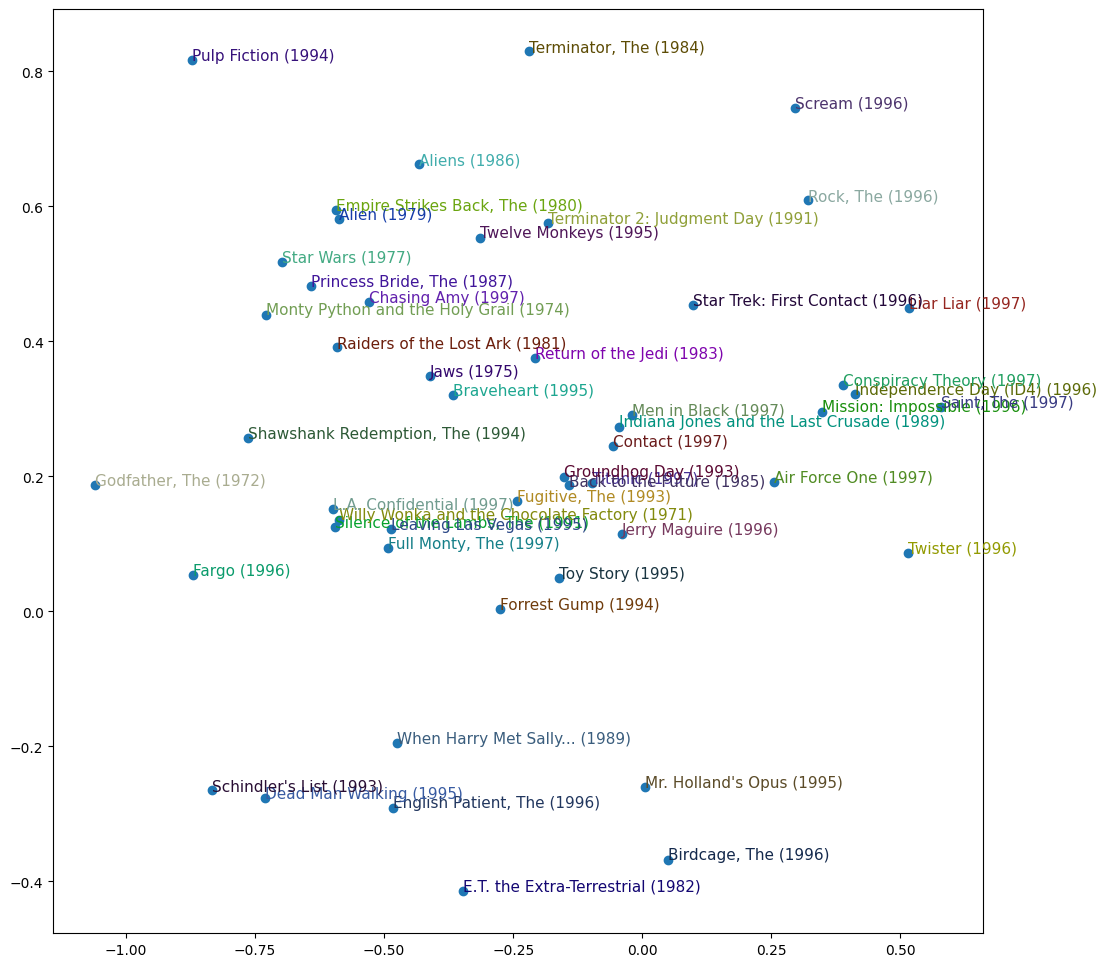

In [38]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([Learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = Learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i,x,y in zip(top_movies[idxs],X,Y):
  plt.text(x,y,i, color = np.random.rand(3)*0.7,fontsize=11)
plt.show()

## Using Fastai.colab library
* we can all the above instead of manually

In [39]:
learn = collab_learner(dls,n_factors=50,y_range=(0,5.5))

In [40]:
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939463,0.954959,00:13
1,0.841215,0.876151,00:13
2,0.724404,0.832099,00:12
3,0.597228,0.816953,00:13
4,0.481373,0.817286,00:12


In [41]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [42]:
movie_bias = learn.model.i_bias.weight.squeeze()
idx = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idx]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

Embedding Distances

In [43]:
movie_factor = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factor,movie_factor[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Before the Rain (Pred dozhdot) (1994)'

In [44]:
idx = distances.argsort(descending=True)
dls.classes['title'][idx]

(#1665) ['Silence of the Lambs, The (1991)','Before the Rain (Pred dozhdot) (1994)','Wedding Gift, The (1994)','Guantanamera (1994)','Affair to Remember, An (1957)','Boot, Das (1981)','Gaslight (1944)','Pather Panchali (1955)','Last Time I Saw Paris, The (1954)','Some Folks Call It a Sling Blade (1993)'...]

## Deep Learning for Collabrative Filtering

In [45]:
# fastai has a rule of thumb for what size of latent factors (size of the embedding) to use - get_emb_sz
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [54]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1] + item_sz[1],n_act),
        nn.ReLU(),
        nn.Linear(n_act,1))
    self.y_range = y_range

  def forward(self,x):
    embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs,dim=1))
    return sigmoid_range(x,*self.y_range)

In [55]:
model = CollabNN(*embs)

In [56]:
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.951110,0.966849,00:17
1,0.930760,0.910937,00:15
2,0.869749,0.896170,00:16
3,0.834223,0.879385,00:17
4,0.784581,0.879708,00:15


In [59]:
learn =collab_learner(dls, use_nn=True, y_range=(0,5.5),loss_func=MSELossFlat(),layers=[100,50])
learn.fit_one_cycle(10,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.003965,0.991643,00:18
1,0.922719,0.950411,00:16
2,0.916193,0.903941,00:18
3,0.887653,0.903609,00:17
4,0.869192,0.879529,00:18
5,0.829119,0.865937,00:17
6,0.776546,0.859024,00:17
7,0.752063,0.850265,00:17
8,0.727256,0.867900,00:16
9,0.659393,0.874399,00:16
